In [8]:
# Imports
import torch
import torch_cluster
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torchsummary import summary
from tqdm.notebook import tqdm

import ogb
# print(ogb.__version__)

import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import time
import json
import copy
import random
import os
import os.path as osp
from pprint import pprint

import importlib
import sys
import pickle

sys.path.append('../')

import training
importlib.reload(training)
import graph_vis
importlib.reload(graph_vis)
import graph_creation
importlib.reload(graph_creation)
import utils
importlib.reload(utils)


from torch_geometric.nn import GraphSAGE
import torch.nn.functional as F
from torch_geometric.loader import NeighborSampler

from ogb.nodeproppred import Evaluator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



import time
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx

In [9]:
def create_erdos_renyi_graphs(sizes, p=0.1, seed=None, save_dir_graphs="./er_graphs", save_dir_data="./er_data"):
    os.makedirs(save_dir_graphs, exist_ok=True)
    os.makedirs(save_dir_data, exist_ok=True)
    graphs_nx = []
    graphs_data = []

    for n in sizes:
        graph_path = os.path.join(save_dir_graphs, f"er_graph_{n}.gpickle")
        data_path = os.path.join(save_dir_data, f"er_graph_{n}.pt")

        # Load or create graph
        if os.path.exists(graph_path):
            with open(graph_path, "rb") as f:
                G = pickle.load(f)
            print(f"Successfully loaded from {graph_path}")
        else:
            G = nx.erdos_renyi_graph(n=n, p=p, seed=seed)
            G = utils.add_louvain_community_labels(G)
            with open(graph_path, "wb") as f:
                pickle.dump(G, f)
            print(f"Saved new graph to {graph_path}")

        graphs_nx.append(G)

        # Load or create Data object
        if os.path.exists(data_path):
            data = torch.load(data_path)
            print(f"Successfully loaded Data from {data_path}")
        else:
            data = from_networkx(G)
            data = utils.create_masks(data)
            torch.save(data, data_path)
            print(f"Saved new Data to {data_path}")

        graphs_data.append(data)

    return graphs_nx, graphs_data

# Usage
sizes = [500,1000,5000,10000]
#sizes = [10, 100, 1000, 10000]
graphs_nx, graphs_data = create_erdos_renyi_graphs(sizes, p=0.1)
print([len(g.nodes) for g in graphs_nx])
print(graphs_data)

Successfully loaded from ./er_graphs\er_graph_500.gpickle
Successfully loaded Data from ./er_data\er_graph_500.pt
Successfully loaded from ./er_graphs\er_graph_1000.gpickle
Successfully loaded Data from ./er_data\er_graph_1000.pt


C:\Users\csaba\AppData\Local\Temp\ipykernel_34412\3068256594.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


Successfully loaded from ./er_graphs\er_graph_5000.gpickle
Successfully loaded Data from ./er_data\er_graph_5000.pt
Successfully loaded from ./er_graphs\er_graph_10000.gpickle
Successfully loaded Data from ./er_data\er_graph_10000.pt
[500, 1000, 5000, 10000]
[Data(edge_index=[2, 25150], y=[500], num_nodes=500, train_mask=[500], test_mask=[500]), Data(edge_index=[2, 100098], y=[1000], num_nodes=1000, train_mask=[1000], test_mask=[1000]), Data(edge_index=[2, 2502890], y=[5000], num_nodes=5000, train_mask=[5000], test_mask=[5000]), Data(edge_index=[2, 9991262], y=[10000], num_nodes=10000, train_mask=[10000], test_mask=[10000])]


In [10]:
for data in graphs_data:
    print(data)
    if data.x is None:
        feature_dim = 32
        data.x = torch.randn(data.num_nodes, feature_dim)


Data(edge_index=[2, 25150], y=[500], num_nodes=500, train_mask=[500], test_mask=[500])
Data(edge_index=[2, 100098], y=[1000], num_nodes=1000, train_mask=[1000], test_mask=[1000])
Data(edge_index=[2, 2502890], y=[5000], num_nodes=5000, train_mask=[5000], test_mask=[5000])
Data(edge_index=[2, 9991262], y=[10000], num_nodes=10000, train_mask=[10000], test_mask=[10000])


Using device: cpu
Random seed set to: 42
Data(edge_index=[2, 25150], y=[500], num_nodes=500, train_mask=[500], test_mask=[500], x=[500, 32])


Epoch 1/10, Loss: 2.3268
Epoch 2/10, Loss: 2.2775
Epoch 3/10, Loss: 2.2532
Epoch 4/10, Loss: 2.2362
Epoch 5/10, Loss: 2.2046
Epoch 6/10, Loss: 2.1921
Epoch 7/10, Loss: 2.1881
Epoch 8/10, Loss: 2.1438
Epoch 9/10, Loss: 2.1227
Epoch 10/10, Loss: 2.1143
Elapsed time for graph with 500 nodes: 0.21 seconds
Data(edge_index=[2, 100098], y=[1000], num_nodes=1000, train_mask=[1000], test_mask=[1000], x=[1000, 32])
Epoch 1/10, Loss: 2.4030
Epoch 2/10, Loss: 2.3442
Epoch 3/10, Loss: 2.2926
Epoch 4/10, Loss: 2.2680
Epoch 5/10, Loss: 2.2542
Epoch 6/10, Loss: 2.2290
Epoch 7/10, Loss: 2.2159
Epoch 8/10, Loss: 2.2195
Epoch 9/10, Loss: 2.2034
Epoch 10/10, Loss: 2.1934
Elapsed time for graph with 1000 nodes: 0.35 seconds
Data(edge_index=[2, 2502890], y=[5000], num_nodes=5000, train_mask=[5000], test_mask=[5000], x=[5000, 32])
Epoch 1/10, Loss: 2.0228
Epoch 2/10, Loss: 1.9710
Epoch 3/10, Loss: 1.9602
Epoch 4/10, Loss: 1.9481
Epoch 5/10, Loss: 1.9348
Epoch 6/10, Loss: 1.9340
Epoch 7/10, Loss: 1.9381
Epoch

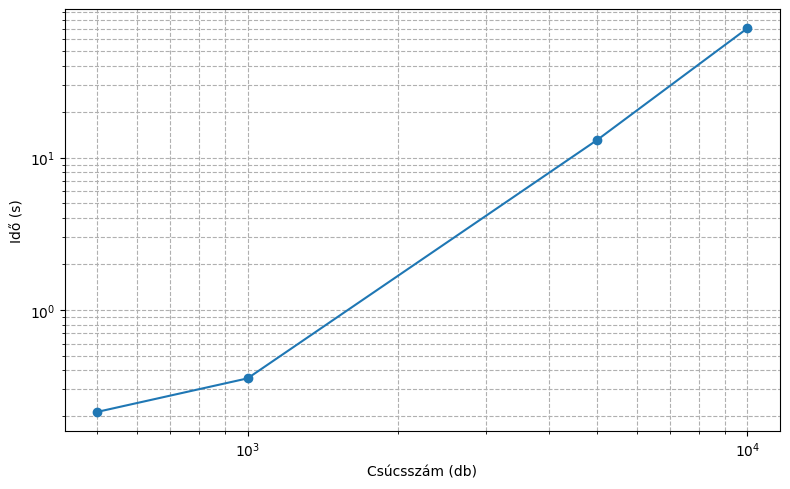

In [11]:
device = utils.set_seeds_and_device() 
elapsed_times = []
graph_sizes = [data.num_nodes for data in graphs_data]


for data in graphs_data:
    print(data)
    

    start_time = time.time()
    # Training function for one graph
    def train_graphsage(data, epochs=1, device='cpu'):
        model = GraphSAGE(
            in_channels=data.x.shape[1],
            hidden_channels=64,
            num_layers=2,
            aggr='mean',
            out_channels=int(data.y.max().item()) + 1,
            dropout=0.5
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

        data = data.to(device)
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        return model

    model = train_graphsage(data, epochs=10, device=device)



    elapsed = time.time() - start_time
    elapsed_times.append(elapsed)
    print(f"Elapsed time for graph with {data.num_nodes} nodes: {elapsed:.2f} seconds")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(graph_sizes, elapsed_times, marker='o')
plt.xlabel('Csúcsszám (db)', fontsize=10)
plt.ylabel('Idő (s)', fontsize=10)
plt.xscale('log')
plt.yscale('log')
# plt.title('Node2Vec Training Time vs Graph Size', fontsize=16, fontweight='bold')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()



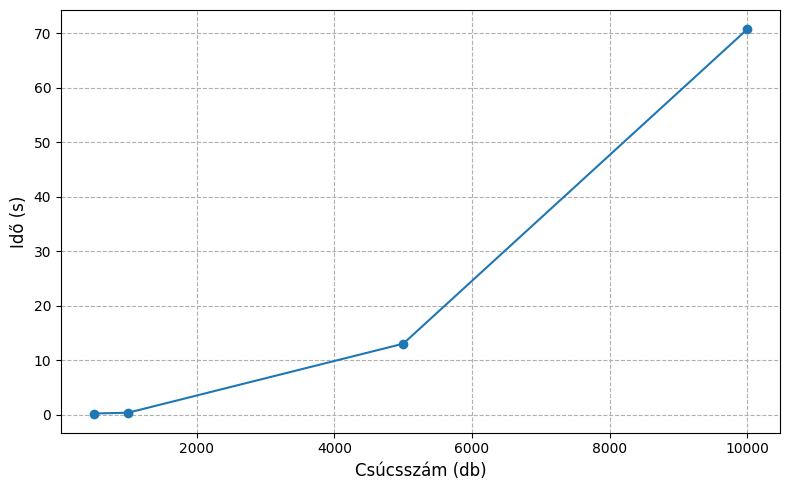

In [12]:
# Linear plot
plt.figure(figsize=(8, 5))
plt.plot(graph_sizes, elapsed_times, marker='o')
plt.xlabel('Csúcsszám (db)', fontsize=12)
plt.ylabel('Idő (s)', fontsize=12)
# plt.title('Node2Vec Training Time vs Graph Size', fontsize=16, fontweight='bold')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

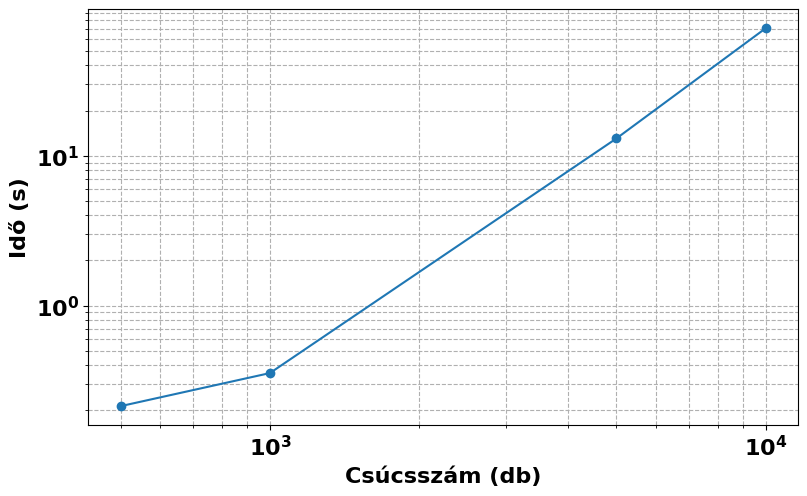

In [17]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(graph_sizes, elapsed_times, marker='o')
plt.xlabel('Csúcsszám (db)', fontsize=16, fontweight='bold')
plt.ylabel('Idő (s)', fontsize=16, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
# plt.title('Node2Vec Training Time vs Graph Size', fontsize=16, fontweight='bold')
plt.grid(True, which="both", ls="--")
plt.tight_layout()

# Make tick labels bold
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

plt.show()

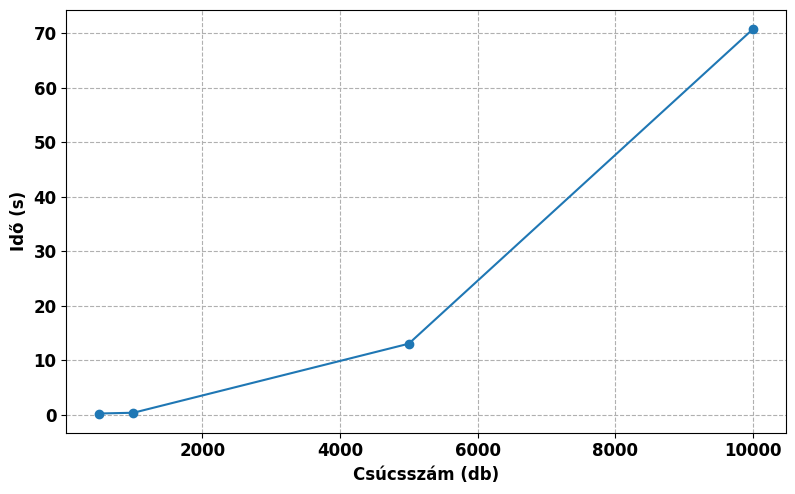

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(graph_sizes, elapsed_times, marker='o')
plt.xlabel('Csúcsszám (db)', fontsize=12, fontweight='bold')
plt.ylabel('Idő (s)', fontsize=12, fontweight='bold')
# plt.title('Node2Vec Training Time vs Graph Size', fontsize=16, fontweight='bold')
plt.grid(True, which="both", ls="--")
plt.tight_layout()

# Make tick labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()